In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/ABHISHEK/OneDrive/Documents/SSH Data/ostst-single-layer-fd-lat-40-urms-5-kf-13-kr-4-beta.nc'

ds = xr.open_dataset(path)

In [3]:
ds

<xarray.Dataset>
Dimensions:          (j: 1, kl: 11439, x: 256, y: 256, z: 1, t: 1826)
Coordinates:
  * j                (j) float64 1.0
  * kl               (kl) float64 0.0 1.0 2.0 ... 1.144e+04 1.144e+04 1.144e+04
  * x                (x) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * y                (y) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * z                (z) float64 0.0
  * t                (t) datetime64[ns] 1970-01-01 1970-01-02 ... 1974-12-31
Data variables: (12/19)
    Lx               float64 ...
    Ly               float64 ...
    Lz               float64 ...
    h                (j) float64 ...
    k                (kl) float64 ...
    l                (kl) float64 ...
    ...               ...
    A0bar_realp      (kl, j) float64 ...
    A0bar_imagp      (kl, j) float64 ...
    tau0             float64 ...
    ssh              (t, y, x) float64 ...
    A0_realp         (t, kl, j) float64 ...
    A0_imagp         (t, kl, j) float64 ...
Attributes:
    source:                    Created with the WaveVortexModel version 3
    model_version:             3.0
    date_created:              28-Feb-2025 16:35:34
    history:                   28-Feb-2025 16:35:34: file created.~          ...
    references:                Early, J., Lelong, M., & Sundermeyer, M. (2021...
    WVTransform:               WVTransformSingleMode
    WVNonlinearFluxOperation:  WVNonlinearFluxQGForced
    beta:                      1.7535936850315176e-11
    r:                         1.4137166941154068e-08
    alpha:                     7.068583470577034e-10
    nu_xy:                     59.6006962601987
    shouldUseLinearDynamics:   0

## Data Loading and Path Configuration

Loading the SSH dataset from netCDF formaations

In [4]:
ssh = ds["ssh"]
ssh

<xarray.DataArray 'ssh' (t: 1826, y: 256, x: 256)>
[119668736 values with dtype=float64]
Coordinates:
  * x        (x) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * y        (y) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * t        (t) datetime64[ns] 1970-01-01 1970-01-02 ... 1974-12-30 1974-12-31
Attributes:
    long_name:  sea-surface height
    units:      m

## Dataset Structure and Metadata

Examining the complete structure of our SSH dataset to understand:
- **Dimensions**: Spatial (x, y) and temporal (t) coordinates
- **Variables**: SSH data and associated model parameormat

This exploration helps us understand the data organization before preprocessing for the CNN model.

In [5]:
ssh.shape

(1826, 256, 256)

In [6]:
nt, nlat, nlon = ssh.shape

## Data Preprocessing for CNN Input

### SSH Data Extraction
Extracting the SSH variable from the xarray dataset and preparing it for neural network input.

### Missing Data Handling
Creating binary masks to identify observed vs. missing data points:
- **Mask = 1**: Observed data points
- **Mask = 0**: Missing data points to be reconstructed


In [7]:
n_samples_lat = 5
n_samples_lon = 5
lat_idxs = np.linspace(0, nlat-1, n_samples_lat, dtype=int)
lon_idxs = np.linspace(0, nlon-1, n_samples_lon, dtype=int)

Purpose: Defines the number of spatial sampling points for your CNN training.

n_samples_lat = 5 & n_samples_lon = 5 : Selects 5 random latitude & longitude positions from your 256×256 spatial grid

lat_idxs & lon_idx to get thearray of 5 random indices



In [9]:
all_values = []
for i in lat_idxs:
    for j in lon_idxs:
        ts = ssh.isel(y=i, x=j)
        all_values.append(ts.values.astype(np.float32))
all_values = np.stack(all_values, axis=0)

In [36]:
lat_idxs, lon_idxs

(array([  0,  63, 127, 191, 255]), array([  0,  63, 127, 191, 255]))

In [34]:
all_values

array([[-0.01006833, -0.01041307, -0.01075653, ...,  0.02169778,
         0.02145583,  0.02120937],
       [ 0.06316785,  0.06311563,  0.06306281, ...,  0.00592113,
         0.00564759,  0.0053755 ],
       [ 0.00082476,  0.0008213 ,  0.00079387, ..., -0.0034029 ,
        -0.00365632, -0.00390286],
       ...,
       [ 0.00082009,  0.00077152,  0.00070047, ..., -0.00363738,
        -0.00386573, -0.00408884],
       [-0.02320427, -0.02305242, -0.02290083, ...,  0.00823113,
         0.00834061,  0.00844257],
       [-0.00484644, -0.00516936, -0.00549639, ...,  0.02571625,
         0.02545988,  0.02519885]], dtype=float32)

### Used above cell to extract data from xrray dataset and get the combination of lat and long

In [10]:
mean_val = all_values.mean()
std_val  = all_values.std()

In [12]:
mean_val, std_val

(0.00010330167, 0.022820394)

In [13]:
window_length = 256
stride = 128
series_count = all_values.shape[0]

X_list, y_list = [], []
for series in all_values:
    n = series.shape[0]
    for start in range(0, n - window_length + 1, stride):
        window_vals = series[start:start + window_length]
        mask = np.zeros(window_length, dtype=np.float32)
        idx = np.random.choice(window_length, size=int(0.1 * window_length), replace=False)
        mask[idx] = 1.0
        data = window_vals.copy()
        data[mask==0] = 0.0
        
        
        data_std = (data - mean_val) / std_val
        vals_std = (window_vals - mean_val) / std_val
        
        
        X_list.append(np.stack([data_std, mask], axis=-1))
        y_list.append(vals_std[..., None])

X = np.stack(X_list, axis=0)
y = np.stack(y_list, axis=0)

## There i used window creation and stripes to managed the training sets
## Then i used the loop to fetch the ssh values and create windows for 1826 i guess step series and used mask 
## As per discussed i used the mean deviation it you have any more suggestion to normalized it let me n=know

In [14]:
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

## CNN Model Architecture

### Two-Channel Input Design
Our 1D CNN uses a sophisticated two-channel input approach:
- **Channel 1**: SSH time series (with missing values)
- **Channel 2**: Binary mask indicating data availability

In [16]:
def build_model(length):
    inp = layers.Input((length, 2))
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(inp)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    out = layers.Conv1D(1, 3, padding="same")(x)
    return models.Model(inp, out)

In [26]:
model = build_model(window_length)
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape")]
)

In [27]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    verbose=1
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.7833 - mape: 115.6469 - val_loss: 0.5155 - val_mape: 219.7770
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3589 - mape: 125.1414 - val_loss: 0.3756 - val_mape: 116.3419
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3215 - mape: 102.2388 - val_loss: 0.3586 - val_mape: 166.0248
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3151 - mape: 81.5132 - val_loss: 0.4051 - val_mape: 205.9075
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2858 - mape: 119.2868 - val_loss: 0.3369 - val_mape: 86.4795
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2917 - mape: 79.1331 - val_loss: 0.3585 - val_mape: 188.1269
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2608 - mape: 77.6933 - val_loss: 0.3126 - val_mape: 59.2345
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2816 - mape: 62.5044 - val_loss: 0.3150 - val_mape: 108.8405
Epoch 9/100
33

 Model Performance Evaluation

### Metrics Used
- **R² Score**: Measures reconstruction quality
- **Mean Squared Error**: Quantifies prediction accuracy
- **Visual Comparison**: Observed vs. predicted time series plots

### Evaluation Strategy
- **Training/Validation Loss**: Monitor learning progress and overfitting
- **R² Score Tracking**: Assess reconstruction capability over epochs
- **Visual Validation**: Compare predicted SSH with true values


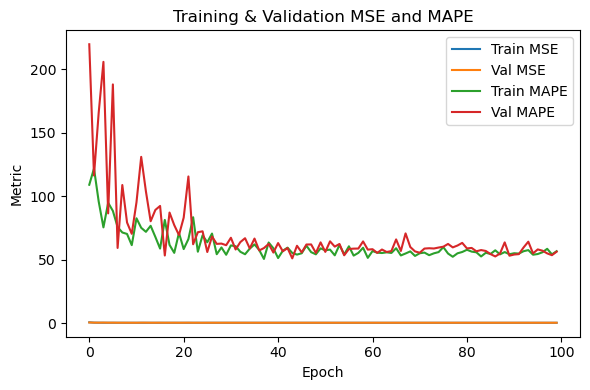

In [28]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")
plt.plot(history.history["mape"], label="Train MAPE")
plt.plot(history.history["val_mape"], label="Val MAPE")
plt.xlabel("Epoch"); plt.ylabel("Metric")
plt.title("Training & Validation MSE and MAPE")
plt.legend(); plt.tight_layout(); plt.show()

In [39]:
from sklearn.metrics import r2_score
y_pred_std = model.predict(X_val)
y_true_std = y_val

# Flatten and invert standardization
y_pred = y_pred_std.flatten() * std_val + mean_val
y_true = y_true_std.flatten() * std_val + mean_val

r2 = r2_score(y_true, y_pred)
print(f"Validation R²: {r2:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Validation R²: 0.7035
Validation Mape: 64.6001


In [32]:
pred_std = y_pred_std[0, :, 0]
pred = pred_std * std_val + mean_val
true = y_true_std[0, :, 0] * std_val + mean_val
mask_val = X_val[0, :, 1]
obs_idx = np.where(mask_val == 1)[0]

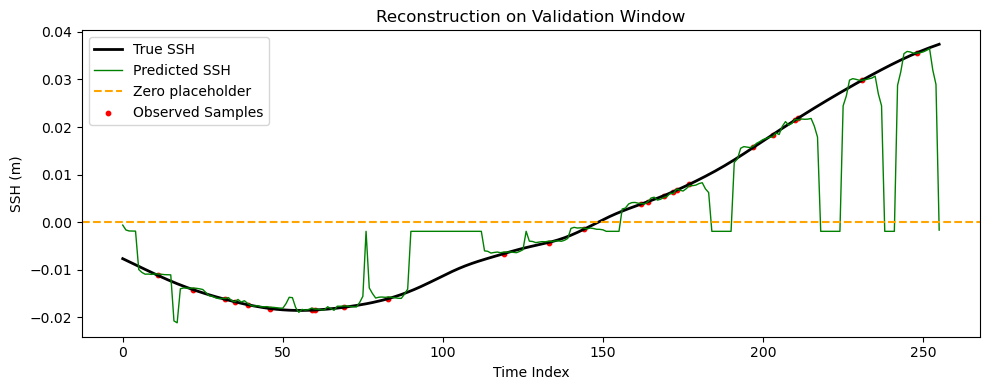

In [33]:
plt.figure(figsize=(10,4))
plt.plot(true, 'k-', lw=2, label="True SSH")
plt.plot(pred, 'g-', lw=1, label="Predicted SSH")
plt.axhline(0, color="orange", ls="--", label="Zero placeholder")
plt.scatter(obs_idx, true[obs_idx], c="red", s=10, label="Observed Samples")
plt.xlabel("Time Index"); plt.ylabel("SSH (m)")
plt.title("Reconstruction on Validation Window")
plt.legend(); plt.tight_layout(); plt.show()